In [44]:
# Import libraries, packages, modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Import ML Algorithms
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Load Data
data=pd.read_csv('df_ss_model.csv')

In [13]:
data.head()

,taxi_out,wheels_off,wheels_on,taxi_in,crs_elapsed_time,air_time,flights,date,mkt_unique_carrier_new,origin_new,dest_new,origin_city_new,origin_state_new,dest_city_new,dest_state_new,month_new,distance_catg_new,dep_hrs_catg_new,arr_hrs_catg_new,arr_delay
0,17,855,933,10,141,98,1,1,0,1,212,1,5,49,13,4,2,3,3,37
1,14,2340,8,30,53,28,1,1,0,1,239,1,5,218,26,4,2,2,2,65
2,22,1653,1848,8,142,115,1,1,0,1,189,1,5,168,8,4,2,0,0,1
3,13,1837,1912,8,140,95,1,1,0,1,212,1,5,49,13,4,2,0,2,5
4,14,1953,2113,8,174,140,1,1,0,1,77,1,5,61,43,4,1,2,2,8


In [14]:
# Defining Features and Target

X=data[['taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_elapsed_time',
       'air_time', 'flights', 'date', 'mkt_unique_carrier_new', 'origin_new',
       'dest_new', 'origin_city_new', 'origin_state_new', 'dest_city_new',
       'dest_state_new', 'month_new', 'distance_catg_new', 'dep_hrs_catg_new',
       'arr_hrs_catg_new']]  # Features
y=data['arr_delay']  # Labels

In [15]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
# 75% training and 25% test

In [6]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [7]:
# Predicting target vaiable for test set
y_pred_rf=clf.predict(X_test)

In [8]:
#After training, check the accuracy using actual and predicted values.

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.05106750519582175


----

## XGBoost

In [12]:
pip install xgboost

  Using cached xgboost-1.4.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [16]:
# convert the dataset into an optimized data structure called 
#Dmatrix that XGBoost supports

data_dmatrix = xgb.DMatrix(data = X, label = y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
            learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
# fit 
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# predict
y_pred_xgb = xg_reg.predict(X_test)

In [27]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_xgb))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [29]:
# Compute the rmse 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %f" % (rmse))

RMSE: 33.812438


In [39]:
# Hyperparameters tuning

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.2,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=4,
                    num_boost_round=50,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)


In [40]:
# cv_results contains train and test RMSE metrics
# for each boosting round.

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,37.618686,0.059439,37.619768,0.166454
1,37.013573,0.300509,37.018214,0.339957
2,36.356117,0.463164,36.363569,0.353435
3,35.866464,0.119973,35.881365,0.222562
4,35.409808,0.211758,35.428196,0.308671


In [41]:
# Extract and print the final boosting round metric.

print((cv_results["test-rmse-mean"]).tail(1))

49    29.034902
Name: test-rmse-mean, dtype: float64


In [42]:
# Visualize Boosting Trees and Feature Importance

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, 
                   num_boost_round=10)


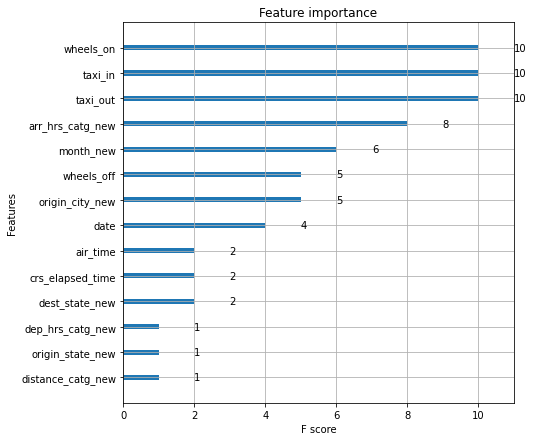

In [43]:
# Plotting the first tree with the matplotlib library:

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()